# KWS_Training
- TinyML - Edge Impulse Model Training analysis
- M.Rovai @24Oct2023

[![Open In Colab <](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Mjrovai/Arduino_Nicla_Vision/blob/main/KWS/KWS_CNN_training.ipynb)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.fftpack
import librosa
import librosa.display
import IPython.display

Get Features Dataset

Go to `Dashboard`in the Studio and download the MFCC Training data and labels files to your computer.

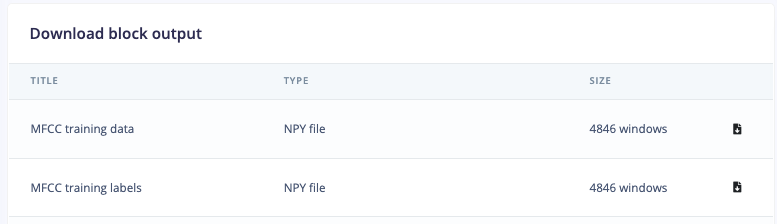

Upload the train and labes to `content` folder.

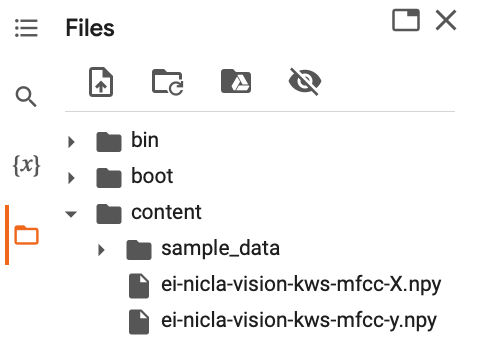

In [ ]:
!ls /content

ei-nicla-vision-kws-mfcc-X.npy	ei-nicla-vision-kws-mfcc-y.npy	sample_data


## Analysing Edge Impulse Model Training

Load the pre-processed data
(For simplification we will only work with the train data)

In [ ]:
X = np.load('ei-nicla-vision-kws-mfcc-X.npy')
Y = np.load('ei-nicla-vision-kws-mfcc-y.npy')[:,0]

In [ ]:
X.shape, Y.shape

((4846, 637), (4846,))

Inspect one of the samples

In [ ]:
image = X[0]
img_length = image.shape[0]
img_length

637

Note that the data is flatten (637). Let's re-shape it (49 x 13)

In [ ]:
columns = 13
rows = int(img_length / columns)
image = np.reshape(image, (rows, columns))
image.shape

(49, 13)

Plot the sample:

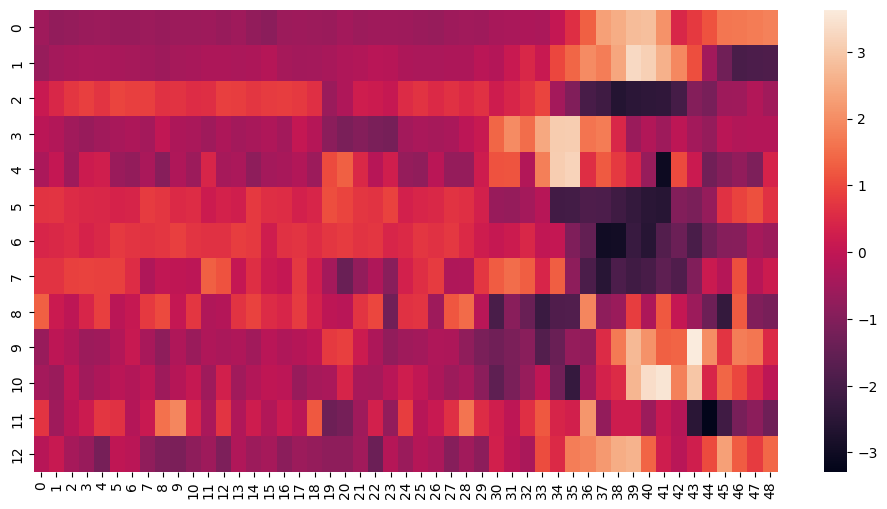

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12,6))
sns.heatmap(image.T);

Inspect labels

In [ ]:
Y[0]

4

In [ ]:
# Find the unique labels and their counts
unique_labels, counts = np.unique(Y, return_counts=True)

# Display the unique labels and their counts
print("Unique labels:", unique_labels)
print("Counts:", counts)

Unique labels: [1 2 3 4]
Counts: [1204 1229 1202 1211]


Edge Impulse store the labels as numbers starting as 1. They are related with our original labels in alphabetic order:

In [ ]:
classes_values = [ "no", "noise", "unknown", "yes" ]
classes = len(classes_values)

Define our labels and split the data up in a test and training set:

In [ ]:
import sys, os, random
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Set random seeds for repeatable results
RANDOM_SEED = 3
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

Y = tf.keras.utils.to_categorical(Y - 1, classes)

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y,
    test_size=0.1,
    random_state=1)

input_length = X_train[0].shape[0]

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
validation_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test))

In [ ]:
def get_reshape_function(reshape_to):
    def reshape(image, label):
        return tf.reshape(image, reshape_to), label
    return reshape

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',
                           mode='min',
                           verbose=1,
                           patience=20)

callbacks = [early_stop]

Train the model:
- For simplicity, we will not use data augmentation

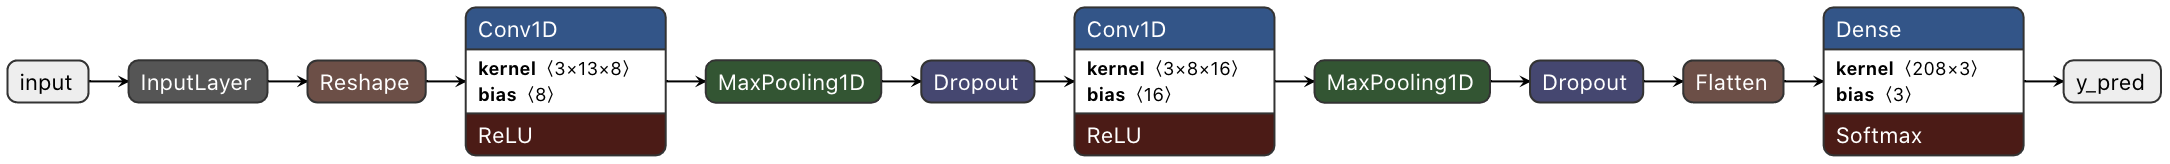

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Dropout, Conv1D, Conv2D, Flatten, Reshape, MaxPooling1D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam

# model architecture
model = Sequential()
model.add(Reshape((int(input_length / 13), 13), input_shape=(input_length, )))
model.add(Conv1D(8, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))
model.add(Dropout(0.25))
model.add(Conv1D(16, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(classes, activation='softmax', name='y_pred'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 49, 13)            0         
                                                                 
 conv1d (Conv1D)             (None, 49, 8)             320       
                                                                 
 max_pooling1d (MaxPooling1  (None, 25, 8)             0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 25, 8)             0         
                                                                 
 conv1d_1 (Conv1D)           (None, 25, 16)            400       
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 13, 16)            0         
 g1D)                                                   

In [ ]:
LR = 0.005
BS = 32
EPOCHS = 100

In [ ]:
# this controls the learning rate
opt = Adam(lr=LR, beta_1=0.9, beta_2=0.999)
# this controls the batch size, or you can manipulate the tf.data.Dataset objects yourself
BATCH_SIZE = BS
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=False)
validation_dataset = validation_dataset.batch(BATCH_SIZE, drop_remainder=False)

# train the neural network
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
history = model.fit(train_dataset, epochs=EPOCHS, validation_data=validation_dataset, verbose=2, callbacks=callbacks)


In [ ]:
def get_test_accuracy(model, x_test, y_test):
    """Test model classification accuracy"""
    test_loss, test_acc = model.evaluate(x=x_test, y=y_test, verbose=0)
    print('Test Accuracy: {acc:0.3f}'.format(acc=test_acc))

def plot_result(history, res= 'loss'):
    plt.plot(history.history[res])
    plt.plot(history.history['val_'+res])
    plt.title(res+' vs. epochs')
    plt.ylabel(res)
    plt.xlabel('Epoch')
    plt.grid()
    if (res == 'loss'):
        plt.legend(['training', 'validation'], loc='upper right')
    else:
        plt.legend(['training', 'validation'], loc='lower right')
    plt.show()


In [ ]:
get_test_accuracy(model, X_test, Y_test)

Test Accuracy: 0.907


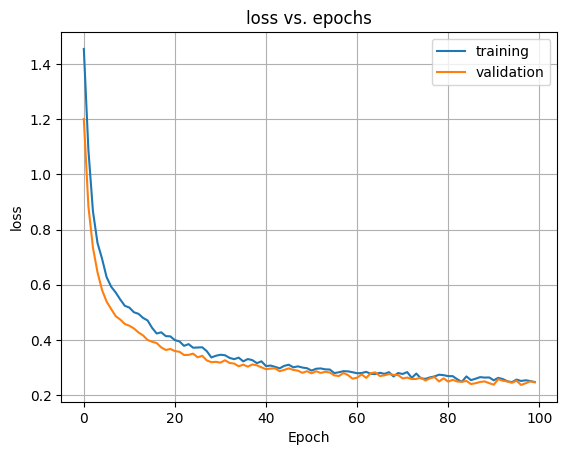

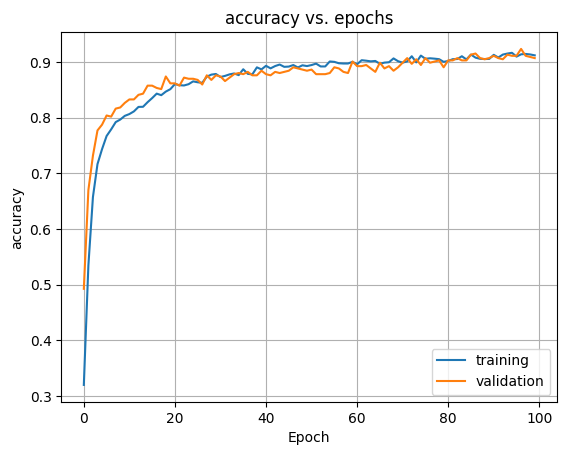

In [ ]:
plot_result(history, res= 'loss')
plot_result(history, res= 'accuracy')

In [ ]:
# Save the model to disk
model.save('cnn_v1_saved_model')

Convert and save TF model to a tflite model

In [ ]:
# Convert TF model to a tflite model
from tensorflow.keras.models import load_model

model_cnn_v1 = load_model('cnn_v1_saved_model')
converter = tf.lite.TFLiteConverter.from_keras_model(model_cnn_v1)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

tflite_model_size = open("cnn_v1.tflite","wb").write(tflite_model)
print("Quantized model (DEFAULT) is {:,} bytes".format(tflite_model_size))

Quantized model (DEFAULT) is 12,268 bytes
